In [57]:
!pip install pmdarima

In [58]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

**Choice of model: ARIMA (Automated Selection)**

Automating the selection for the ARIMA model helps to find an optimal order for the p, d, and q parameters.

In [59]:
# NVIDIA dataset
df = yf.download(
    'NVDA',
    '2015-01-01',
    '2023-10-21'
)

df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,5.032500,5.070000,4.952500,5.032500,4.833230,11368000
2015-01-05,5.032500,5.047500,4.925000,4.947500,4.751595,19795200
2015-01-06,4.955000,4.960000,4.792500,4.797500,4.607536,19776400
2015-01-07,4.832500,4.875000,4.770000,4.785000,4.595529,32180800
2015-01-08,4.840000,4.995000,4.837500,4.965000,4.768404,28378000
...,...,...,...,...,...,...
2023-10-16,450.630005,462.250000,449.119995,460.950012,460.950012,37509900
2023-10-17,440.000000,447.540009,424.799988,439.380005,439.380005,81233300
2023-10-18,425.910004,432.190002,418.250000,421.959991,421.959991,62729400


In [60]:
# Checking for stationary data with the Augmented Dicky Fuller (ADF) test
def test_adf(timeseries):
  print('Results of dickey fuller test')
  adft = adfuller(timeseries, autolag = 'AIC')
  output = pd.Series(adft[0:4], index = ['Test Statistics', 'p-value', 'No. of lags used', 'No. of observations used'])
  for key, value in adft[4].items():
    output['Critical value (%s)' % key] = value
  print(output)

test_adf(df['Close'])

Results of dickey fuller test
Test Statistics                0.487246
p-value                        0.984480
No. of lags used              27.000000
No. of observations used    2188.000000
Critical value (1%)           -3.433342
Critical value (5%)           -2.862862
Critical value (10%)          -2.567474
dtype: float64


From the test results, it is evident that test Statistics is greater than the critical values, so p>0.05, we fail to reject the null hypothesis meaning that the time series data is non-stationary.

<Figure size 640x480 with 0 Axes>

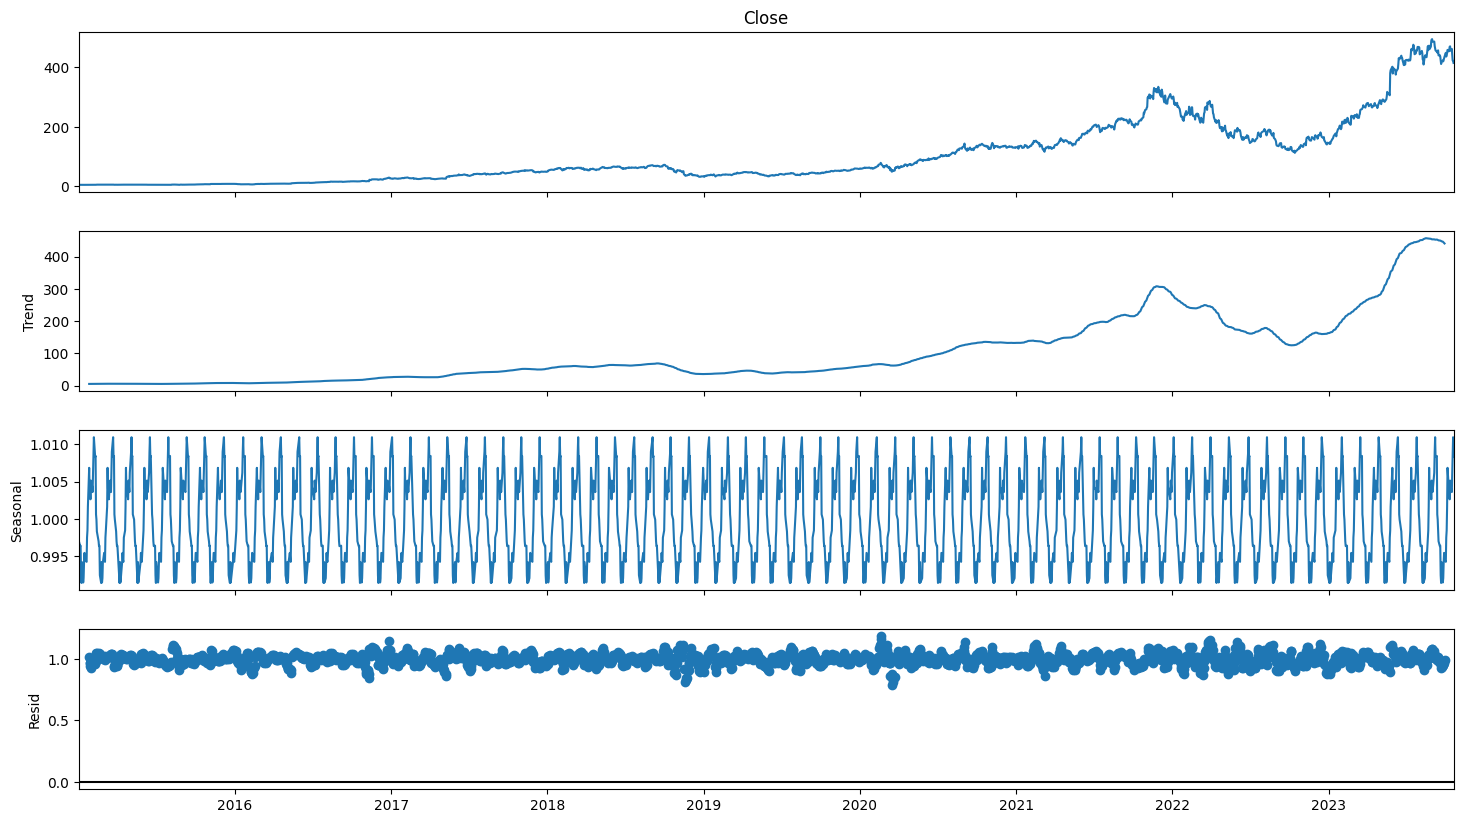

In [61]:
# Let's have a look at the trend and seasonality of NVDA's close prices
result = seasonal_decompose(df['Close'], model = 'multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16,9)

In [62]:
# Take the log of the close prices
df_log = np.log(df['Close'])

# Subtract the moving average
moving_average = df_log.rolling(12).mean()
df_log_minus_mean = df_log - moving_average
df_log_minus_mean.dropna(inplace=True)

In [63]:
# Checking for stationary data again with the Augmented Dicky Fuller (ADF) test
test_adf(df_log_minus_mean)

Results of dickey fuller test
Test Statistics            -1.000880e+01
p-value                     1.801573e-17
No. of lags used            1.100000e+01
No. of observations used    2.193000e+03
Critical value (1%)        -3.433335e+00
Critical value (5%)        -2.862859e+00
Critical value (10%)       -2.567472e+00
dtype: float64


It is evident that test Statistics is less than the critical values, so p<0.05, we reject the null hypothesis meaning that the time series data is stationary.

As we move on to build the model and create the train and test sets, we are now going to work with the original data prior to the log transformation for better ease with visualising the stock prices rather than the log values in this context.

In [64]:
# Split train and test set
data = list(df['Close'])
train_data = data[:int(len(df) * 0.8)]
test_data = data[int(len(df) * 0.8):]

In [91]:
# Apply auto_arima function to find an optimal model selection
stepwise_fit = auto_arima(train_data,trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.44 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=10102.051, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=9533.191, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=9175.084, Time=0.24 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=9124.925, Time=0.31 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=8970.469, Time=0.41 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=8829.474, Time=0.38 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.68 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=0.73 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=8831.465, Time=0.81 sec

Best model:  ARIMA(5,2,0)(0,0,0)[0]          
Total fit time: 6.584 seconds


From the above results, it is clear that ARIMA model finds the optimal order which is (1,1,0), it means:
- p=5, where p  denotes the number of lag observations in the model; also known as the lag order.
- d=2, where d denotes the number of times that the raw observations are differenced to make the series stationary; also known as the degree of differencing.
- q=0, where q denotes the size of the moving average window; also known as the order of the moving average.

In [86]:
# Build the model
model = sm.tsa.arima.ARIMA(data, order=(5,2,0))
model = model.fit()

In [83]:
len(test_data)

444

In [87]:
# Use model to predict test data
start = len(train_data) + 1
end = len(train_data) + len(test_data)
pred = model.predict(start = start, end = end)

In [88]:
pred

array([267.49172899, 257.59969907, 247.52077189, 234.99786084,
       226.8650192 , 228.07011118, 215.41758926, 221.9139378 ,
       213.95344506, 226.05016352, 245.32645046, 248.25038262,
       256.11963671, 242.12236601, 248.44651627, 250.63719389,
       252.41934627, 268.90149284, 259.21014503, 240.30652556,
       243.17806467, 268.69618565, 266.61347446, 240.21035631,
       233.32595495, 235.21743078, 221.68033747, 231.34784062,
       236.62164935, 243.08872758, 233.79299276, 244.34181343,
       239.91541205, 228.5308456 , 208.90862174, 211.27444583,
       228.89479997, 223.30080098, 217.07736884, 210.88185157,
       233.28260911, 249.15116362, 249.52718404, 269.20908886,
       275.5365901 , 274.83382833, 261.22756212, 288.19984007,
       281.94995919, 284.57976315, 288.67780041, 280.76036394,
       275.71566867, 265.46125213, 273.48272446, 255.31264125,
       237.35514738, 236.39543971, 225.46845361, 211.01412023,
       204.6483388 , 215.70982601, 206.88279522, 212.76

<Axes: xlabel='Date'>

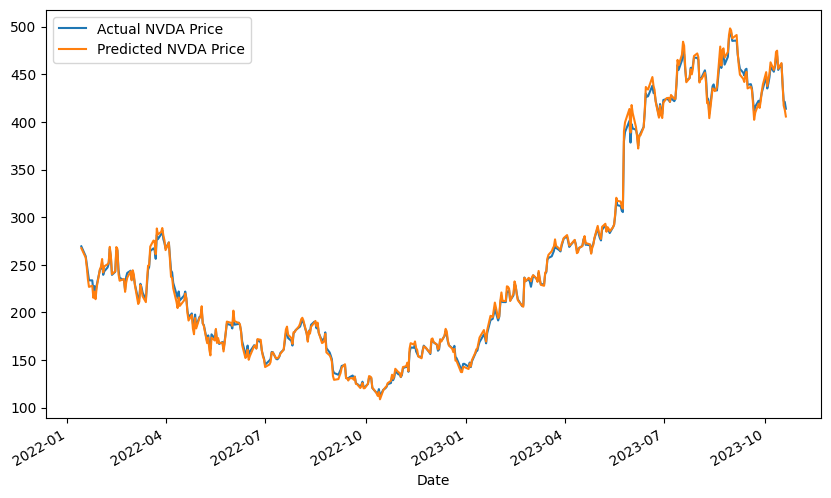

In [89]:
# Plot model's performance on test data
plt.figure(figsize=(10,6), dpi=100)
df['Close'][-444:].plot(label='Actual NVDA Price', legend=True)
pred = pd.Series(pred,index=df['Close'].index[-444:])
pred.plot(label='Predicted NVDA Price', legend=True)

In [94]:
# Predicting the close price for the next 12 trading days (23th Oct - 7 Nov)
predicted_prices = model.predict(start=end+1,end=end+12)
predicted_prices = predicted_prices[2:]
predicted_prices

array([376.60517727, 369.28211683, 360.71684751, 351.82932593,
       342.6177023 , 333.60511136, 325.14780428, 316.60299845,
       307.81112739, 298.95351839])

In [95]:
# Export the predictions to a CSV file
df = pd.DataFrame({'Close': predicted_prices.ravel()})
df.to_csv('N_Ashwin_Kumar_Project_1.csv', index=True)